# Sanity Checking the NQG simulation

This notebook performs a simulation run with the default parameter set
for a single run. It is meant to provide quick diagnostics on the model
capabilities.



## Part 1. Dependences & Set-up

In [11]:
import sys
sys.path.append('../')

import os

import numpy as np
import pandas as pd
from collections import defaultdict

import colorsys
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from netgraph import Graph

from cadCAD_tools import easy_run

pio.renderers.default = "png" # For GitHub rendering

## Part 2. Simulation set-up & execution

In [2]:
from nqg_model.params import INITIAL_STATE
from nqg_model.params import SINGLE_RUN_PARAMS
from nqg_model.params import TIMESTEPS
from nqg_model.params import SAMPLES
from nqg_model.structure import NQG_MODEL_BLOCKS

default_run_args = (INITIAL_STATE,
                     {k: [v] for k, v in SINGLE_RUN_PARAMS.items()},
                    NQG_MODEL_BLOCKS,
                    TIMESTEPS,
                    SAMPLES)
sim_df = easy_run(*default_run_args, assign_params=False).set_index('days_passed')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 22, 1, 10)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 22, 1, 10)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: local_simulations
Execution Mode: single_threaded


Flattening results:   0%|          | 0/501 [00:00<?, ?it/s]

Total execution time: 0.74s


In [3]:
sim_df.head(5)

,delta_days,users,user_round_decisions,delegatees,trustees,action_matrix,vote_matrix,per_project_voting,oracle_state,simulation,subset,run,timestep
days_passed,,,,,,,,,,,,,
0.0,NaN,[],{},{},{},{},{},{},"OracleState(pagerank_results={}, reputation_bo...",0,0,1,0
1.0,1.0,[],{},{},{},{},{},{},"OracleState(pagerank_results={}, reputation_bo...",0,0,1,1
2.0,1.0,"[User(label=0, reputation=<ReputationCategory....","{0: Action.Abstain, 2: Action.Delegate}",{2: []},"{0: {}, 2: {}}","{0: {}, 2: {}}","{0: {'proj_7': 0.0, 'proj_11': 0.0, 'proj_2': ...","{'proj_7': 0.0, 'proj_11': 0.0, 'proj_2': 0.0,...","OracleState(pagerank_results={0: 0.5, 2: 0.5},...",0,0,1,2
3.0,1.0,"[User(label=0, reputation=<ReputationCategory....","{0: Action.Abstain, 2: Action.Delegate}",{2: []},"{0: {}, 2: {}}","{0: {}, 2: {}}","{0: {'proj_7': 0.0, 'proj_11': 0.0, 'proj_2': ...","{'proj_7': 0.0, 'proj_11': 0.0, 'proj_2': 0.0,...","OracleState(pagerank_results={0: 0.5, 2: 0.5},...",0,0,1,3
4.0,1.0,"[User(label=0, reputation=<ReputationCategory....","{0: Action.Abstain, 2: Action.Delegate}",{2: []},"{0: {}, 2: {}}","{0: {}, 2: {}}","{0: {'proj_7': 0.0, 'proj_11': 0.0, 'proj_2': ...","{'proj_7': 0.0, 'proj_11': 0.0, 'proj_2': 0.0,...","OracleState(pagerank_results={0: 0.5, 2: 0.5},...",0,0,1,4


In [4]:
sim_df.columns

Index(['delta_days', 'users', 'user_round_decisions', 'delegatees', 'trustees',
       'action_matrix', 'vote_matrix', 'per_project_voting', 'oracle_state',
       'simulation', 'subset', 'run', 'timestep'],
      dtype='object')

## Part 3. Compute Metrics

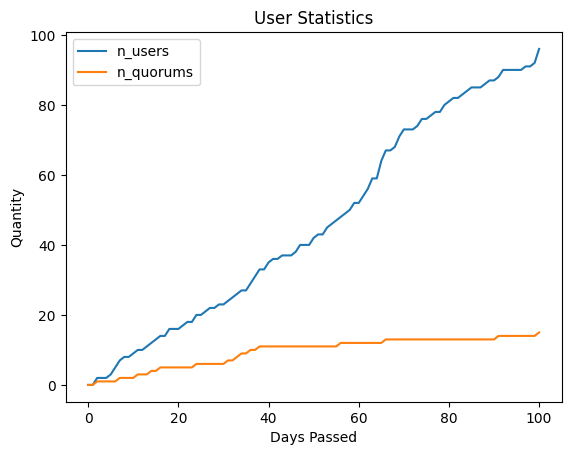

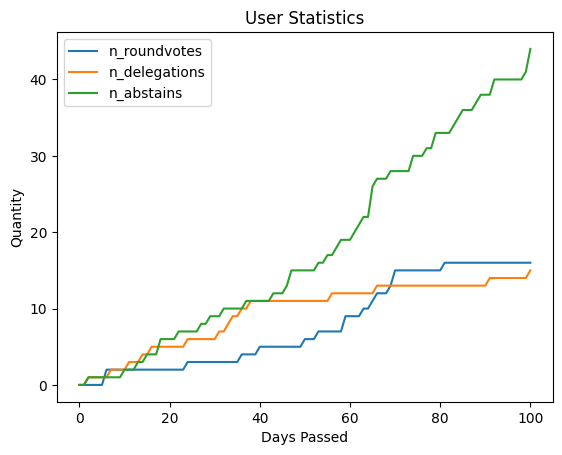

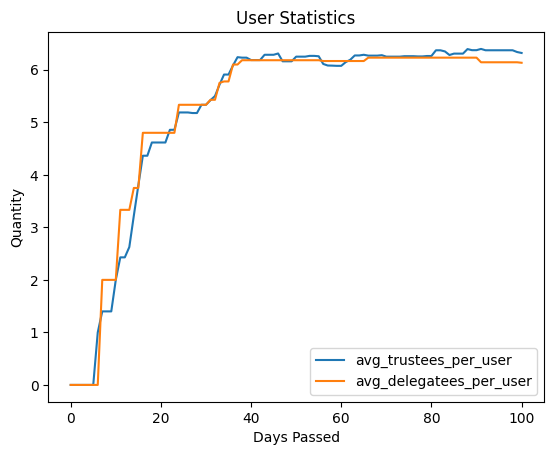

In [5]:
from nqg_model.types import Action
# Global metrics

metrics = {
    'n_users': lambda row: len(row.users),
    'n_quorums': lambda row: len(row.delegatees),
    'n_roundvotes': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.RoundVote]),
    'n_delegations': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.Delegate]),
    'n_abstains': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.Abstain]),
    'avg_trustees_per_user': lambda row: sum(len(l) for l in row.trustees.values()) / len(row.trustees) if len(row.trustees) > 0 else 0.0,
    'avg_delegatees_per_user': lambda row: sum(len(l) for l in row.delegatees.values()) / len(row.delegatees) if len(row.delegatees) > 0 else 0.0,
}



new_df = sim_df.apply(metrics.values(), axis='columns')
new_df.columns = list(metrics.keys())

new_df[['n_users', 'n_quorums']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()

new_df[['n_roundvotes', 'n_delegations', 'n_abstains']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()


new_df[['avg_trustees_per_user', 'avg_delegatees_per_user']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_51434/3580234388.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_51434/3580234388.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



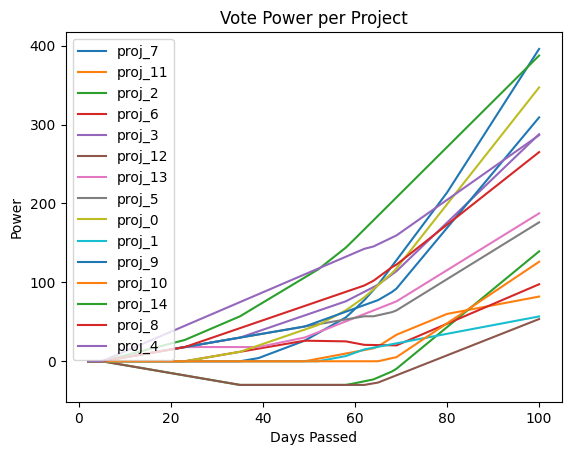

In [6]:
# Per project metrics

per_proj_votes = sim_df.per_project_voting.apply(pd.Series).dropna()
per_proj_votes.plot(title='Vote Power per Project', xlabel='Days Passed', ylabel='Power')
plt.show()

## Part 4. Compute Trust & Delegation Graph

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning:

invalid value encountered in divide



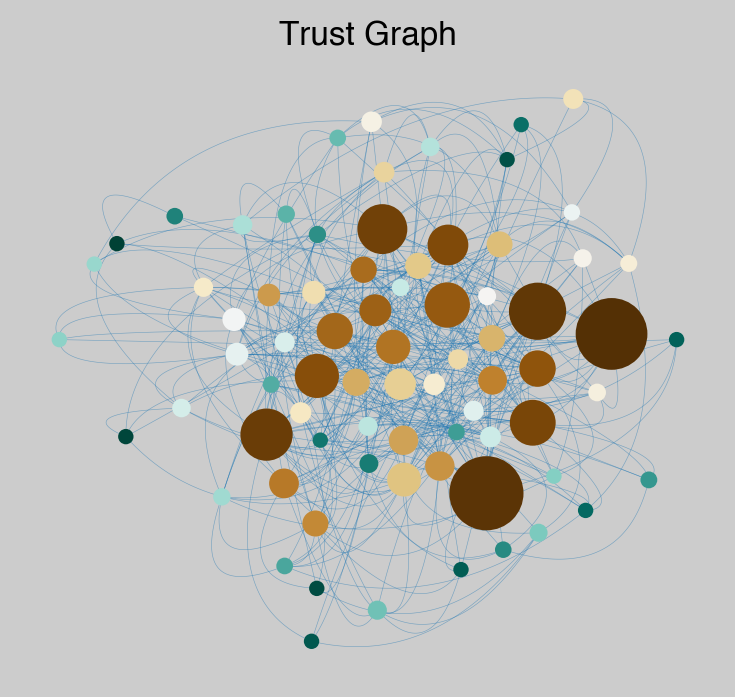

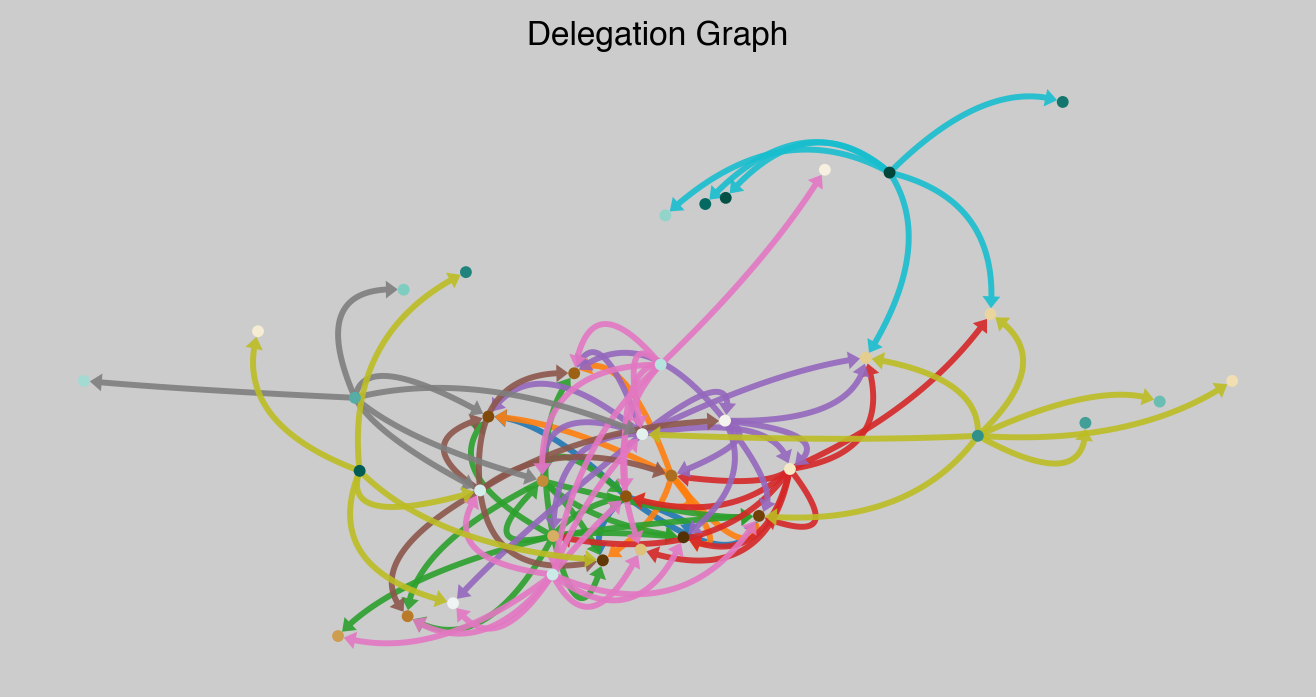

In [105]:

trust_graph_per_day = sim_df.trustees.map(nx.DiGraph)
delegatee_graph_per_day = sim_df.delegatees.map(nx.DiGraph)

def sample_colors_from_hue(N):
    import colorsys
    HSV_tuples = [(x*1.0/N, 1.0, 0.8) for x in range(N)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    return list(RGB_tuples)

cmap = matplotlib.colormaps['BrBG']

def render_graph(G, 
                 weights,
                   K=1, 
                   q=1, 
                   title="", 
                   a=1, 
                   node_color=None,
                   edge_color=None,
                   edge_alpha=0.5,
                   edge_width=0.1,
                   **kwargs):
    sizes = {k: a + K * v ** q for k, v in weights.items()}
    if node_color is None:
        node_color = {k: cmap(i / len(weights)) for i, k in enumerate(sorted(weights.keys()))}
    else:
        pass
    fig = plt.figure(figsize=(12, 4), dpi=200) 
    ax = fig.add_subplot(1, 1, 1)
    g = Graph(G, 
              ax=ax,
              node_size=sizes,
              node_edge_width=0,
              edge_width=edge_width,
              node_color=node_color,
              edge_alpha=edge_alpha,
              edge_color=edge_color,
              **kwargs)
    ax.set_facecolor(colorsys.hsv_to_rgb(0.0, 0.0, 0.8))
    fig.set_facecolor(colorsys.hsv_to_rgb(0.0, 0.0, 0.8))
    plt.title(title, fontname='Helvetica')
    plt.show()

i = -1
G = trust_graph_per_day.iloc[i]
weights = sim_df.iloc[i].oracle_state.pagerank_results
render_graph(G, 
             weights, 
             K=20, 
             q=0.5, 
             a=0, 
             title="Trust Graph",
             edge_layout='curved',
             scale=(4,1))

G = delegatee_graph_per_day.iloc[i]
weights = {k: 0 for k in G.nodes}
weights |= {k: len(v) * 0.2 for k, v in sim_df.iloc[i].delegatees.items()}

quorums = sim_df.iloc[i].delegatees

source_color_map = {k: matplotlib.colormaps['tab10'](i/len(quorums))
                    for i, k in enumerate(quorums.keys())}

edge_color = {(a,b): source_color_map[a] for (a, b) in G.edges}
render_graph(G, weights, 
             K=0, 
             q=1, 
             a=1, 
             title='Delegation Graph', 
             edge_color=edge_color,
             edge_width=1.0,
             edge_alpha=0.9,
             arrows=True,
             edge_layout='curved',
             scale=(4,1))

In [87]:
G.edges.data()

OutEdgeDataView([(7, 0, {}), (7, 3, {}), (7, 2, {}), (7, 5, {}), (9, 3, {}), (9, 8, {}), (9, 0, {}), (9, 2, {}), (9, 5, {}), (9, 7, {}), (11, 7, {}), (11, 3, {}), (11, 0, {}), (11, 10, {}), (11, 2, {}), (13, 10, {}), (13, 5, {}), (13, 7, {}), (13, 0, {}), (13, 8, {}), (13, 2, {}), (13, 12, {}), (13, 3, {}), (13, 11, {}), (20, 16, {}), (20, 17, {}), (20, 7, {}), (20, 13, {}), (20, 3, {}), (20, 0, {}), (20, 14, {}), (20, 9, {}), (23, 16, {}), (23, 3, {}), (23, 0, {}), (23, 8, {}), (23, 20, {}), (23, 9, {}), (25, 11, {}), (25, 16, {}), (25, 23, {}), (25, 13, {}), (25, 24, {}), (25, 8, {}), (25, 5, {}), (25, 20, {}), (26, 5, {}), (26, 8, {}), (26, 9, {}), (26, 2, {}), (26, 10, {}), (26, 23, {}), (27, 7, {}), (27, 24, {}), (27, 12, {}), (27, 0, {}), (27, 10, {}), (27, 25, {}), (27, 3, {}), (27, 26, {}), (27, 14, {}), (33, 25, {}), (33, 27, {}), (33, 11, {}), (33, 8, {}), (33, 14, {}), (33, 22, {}), (33, 7, {}), (47, 38, {}), (47, 26, {}), (47, 11, {}), (47, 25, {}), (47, 5, {}), (47, 35, {}

In [ ]:
for edge